In [1]:
%load_ext autoreload
%autoreload 2


In [24]:
# Modify path to find code directory:
import sys
sys.path.append('../code/')

import networkx as nx
import matplotlib.pyplot as plt
import scipy as sp
import itertools


In [3]:
from structures import *


In [4]:
agents = [
    Agent(receptivity=0.5,persuasiveness=0.5),
    Agent(receptivity=0.5,persuasiveness=0.5),
    Agent(receptivity=0.5,persuasiveness=0.5),
    Agent(receptivity=0.5,persuasiveness=0.5),
    Agent(receptivity=0.5,persuasiveness=0.5),
]

# Add some connections (only use inner circle):
agents[0].inner_circle.append(agents[1].id)
agents[1].inner_circle.append(agents[0].id)
agents[1].inner_circle.append(agents[2].id)
agents[2].inner_circle.append(agents[1].id)
agents[1].inner_circle.append(agents[3].id)
agents[3].inner_circle.append(agents[1].id)
agents[3].inner_circle.append(agents[4].id)
agents[4].inner_circle.append(agents[3].id)

# - REMINDER - Do we want to have connections automatically propagate both ways when specified?

# Build simulation environment:
env = Environment(agents, seed=182)
print(env)


<Environment with 0/5 informed agents>


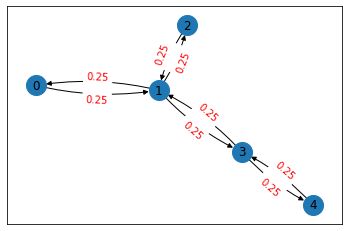

In [5]:
env.plot_network_graph()


In [127]:
intervention_n = 2

action_space = list(itertools.combinations(env.agent_ids, intervention_n))
state_space = list(itertools.product([0,1], repeat=len(env.agent_ids)))

T = np.zeros((len(action_space), len(state_space), len(state_space)))

for i, actions in enumerate(action_space):
    for j, state1 in enumerate(state_space):
        for k, state2 in enumerate(state_space):

            # Check that the new state is consistent with the action alone
            consistent = 0
            for action in actions:
                if state2[action] == 1:
                    consistent += 1
                
            if consistent == intervention_n:
                # Calculate the probabilities of influence occuring to each next state
                total_influence_prob = []
                for n_state, n_val in enumerate(state2):
                    next_state_prob = []
                    if n_state in actions:
                        next_state_prob.append(0)
                    else:
                        for c_state, c_val in enumerate(state1):
                            if c_val == 1:
                                next_state_prob.append(1 - env.influence.matrix[c_state, n_state])
                            else:
                                next_state_prob.append(1)
                    prob_no_influence = np.prod(next_state_prob)
                    prob_influence = 1 - prob_no_influence
                    if n_val == 0:
                        total_influence_prob.append(prob_no_influence)
                    else:
                        total_influence_prob.append(prob_influence)
                if i == 0 and j == 0:
                    print(actions, state1, state2, total_influence_prob)

                total_probability = np.prod(total_influence_prob)
                T[i,j,k] = total_probability

                    
 



In [110]:
action_space[0]

(0, 1)

In [140]:
T[0,1,:]

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.75, 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  ])

In [112]:
state_space[0]

(0, 0, 0, 0, 0)

In [116]:
state_space[24]

(1, 1, 0, 0, 0)

0.0

In [69]:
T[0,:,:]

array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [51]:
state_space = list(itertools.product([0,1], repeat=len(env.agent_ids)))
state_space

[(0, 0, 0, 0, 0),
 (0, 0, 0, 0, 1),
 (0, 0, 0, 1, 0),
 (0, 0, 0, 1, 1),
 (0, 0, 1, 0, 0),
 (0, 0, 1, 0, 1),
 (0, 0, 1, 1, 0),
 (0, 0, 1, 1, 1),
 (0, 1, 0, 0, 0),
 (0, 1, 0, 0, 1),
 (0, 1, 0, 1, 0),
 (0, 1, 0, 1, 1),
 (0, 1, 1, 0, 0),
 (0, 1, 1, 0, 1),
 (0, 1, 1, 1, 0),
 (0, 1, 1, 1, 1),
 (1, 0, 0, 0, 0),
 (1, 0, 0, 0, 1),
 (1, 0, 0, 1, 0),
 (1, 0, 0, 1, 1),
 (1, 0, 1, 0, 0),
 (1, 0, 1, 0, 1),
 (1, 0, 1, 1, 0),
 (1, 0, 1, 1, 1),
 (1, 1, 0, 0, 0),
 (1, 1, 0, 0, 1),
 (1, 1, 0, 1, 0),
 (1, 1, 0, 1, 1),
 (1, 1, 1, 0, 0),
 (1, 1, 1, 0, 1),
 (1, 1, 1, 1, 0),
 (1, 1, 1, 1, 1)]

In [45]:
T.shape

(10, 10, 10)

In [40]:
if 0 in action_space[0]:


hi


In [23]:
np.array
for agent in env.agents:

{0: <structures.Agent at 0x11f636390>,
 1: <structures.Agent at 0x11f6363c8>,
 2: <structures.Agent at 0x11f636400>,
 3: <structures.Agent at 0x11f636438>,
 4: <structures.Agent at 0x11f636470>}

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 3),
 (2, 4),
 (3, 4)]